# Learning with Keras 
----------------------------------------------------
This is a demo of a Binary classification, I apply all encoding techniches que you already know, we are no looking to do a bag of words instead we are trying to figureout the sequence of words, order matter in a sentences and in particular in Sentiment analysis

# Loading tools 

In [263]:
#this is to force to be compatible con Python 3.xx
#from __future__ import absolute_import
#from __future__ import print_function
%matplotlib inline 
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
 
import seaborn as sns
import nltk
import csv
import itertools
import operator
import unicodedata
import nltk
import sys
import os
import time, re
from datetime import datetime
import collections
from bs4 import BeautifulSoup 
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
stemmer = SnowballStemmer("english")


## Loading utilities tools to process text

In [264]:
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.cross_validation import train_test_split

## Loading actual Tools and Layers of Deep Learning

In [265]:

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization #https://github.com/fchollet/keras/blob/master/examples/kaggle_otto_nn.py
from keras.layers.advanced_activations import PReLU, LeakyReLU, ELU, ParametricSoftplus, ThresholdedLinear, ThresholdedReLU
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.optimizers import SGD
from keras.callbacks import History, EarlyStopping
from keras.preprocessing.text import Tokenizer

# this is to be sure that al results in development are comparable
np.random.seed(1337)  # for reproducibility

## actual code

In [266]:
df = pd.read_csv("data/Tweets_airline.csv")
vocabulary_size = 0
unknown_token = "UNKNOWN_TOKEN"
sentence_start_token = "SENTENCE_START"
sentence_end_token = "SENTENCE_END"

#print (df.shape)
#print (df.info())

## Some small utilities

In [267]:
def cleanword(w):        
    return re.sub('[^a-zA-Z0-9,]' , ' ' , w)  

def cleantext(review):
    review = BeautifulSoup(review ,"lxml").get_text()
    review_words = cleanword(review.lower()).split()    
#    stop = stopwords.words('english')
#    stemmed_words = [stemmer.stem(w) for w in review_words if w not in stop]
#    return " ".join(stemmed_words)
    return " ".join(review_words)


df["text"]  = df["text"].apply(cleantext)
print "An example of a single message:", df.head(5)['text']


An example of a single message: 0                     virginamerica what dhepburn said
1    virginamerica plus you ve added commercials to...
2    virginamerica i didn t today must mean i need ...
3    virginamerica it s really aggressive to blast ...
4    virginamerica and it s a really big bad thing ...
Name: text, dtype: object


## Tokenize all sentences
it is a good Idea to tokenize with Keras, instead of bag of words


In [268]:
################# ML ##############################################3

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split 

X_clean = df["text"] 

sentences = X_clean
tokenized_sentences = [nltk.word_tokenize(sent) for sent in sentences]
word_freq = nltk.FreqDist(itertools.chain(*tokenized_sentences))
print "Found %d uniq words tokens." % len(word_freq.items())
w_tokens = len(word_freq.items())
vocabulary_size = w_tokens +1
print "Example of a tokenize sentence", tokenized_sentences[33]

Found 15100 uniq words tokens.
Example of a tokenize sentence [u'virginamerica', u'awaiting', u'my', u'return', u'phone', u'call', u',', u'just', u'would', u'prefer', u'to', u'use', u'your', u'online', u'self', u'service', u'option']


In [269]:
max_words= len(word_freq.items())+1
vocab = word_freq.most_common(vocabulary_size-1)
index_to_word = [x[0] for x in vocab]
index_to_word.append(unknown_token)
word_to_index = dict([w,i] for i,w in enumerate(index_to_word))
print "using vocabulary size %d" % vocabulary_size
for i, sent in enumerate (tokenized_sentences):
    tokenized_sentences[i] = [w if w in word_to_index else unknown_token for w in sent]
X_clean = np.asarray([[word_to_index[w] for w in sent[1:]] for sent in tokenized_sentences])
X_clean = np.asarray(X_clean)
print "Example of a sequence sentence", X_clean[33]


using vocabulary size 15101
Example of a sequence sentence [2271, 12, 489, 98, 82, 6, 45, 76, 2265, 0, 262, 22, 205, 1953, 46, 490]


In [270]:
# LabelEncoder is a utility class to help normalize labels such 
# that they contain only values between 0 and n_classes-1. 
le = preprocessing.LabelEncoder()
le.fit(df["airline_sentiment"])
print "Example of a sentiment sentence: ", df["airline_sentiment"][33]
y = le.transform(df["airline_sentiment"])
y = np.asarray(y)
print "Example of a sentiment After Encoder: ",y[33]

X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2) #, random_state=42

print("Convert class vector to binary class matrix (for use with categorical_crossentropy)")
y_train = np.array(y_train, dtype = int)
y_test = np.array(y_test, dtype = int)
nb_classes = np.max(y_train)+1
nb_classes = int(nb_classes)
print(nb_classes, 'classes')

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)
print "Example of a sentiment After categorical Encoder: ",Y_train[1]

Example of a sentiment sentence:  negative
Example of a sentiment After Encoder:  0
Convert class vector to binary class matrix (for use with categorical_crossentropy)
(3, 'classes')
Example of a sentiment After categorical Encoder:  [ 1.  0.  0.]


In [271]:
print("Vectorizing sequence data...")
tokenizer = Tokenizer(nb_words=max_words)
X_train = tokenizer.sequences_to_matrix(X_train, mode="binary")
X_test = tokenizer.sequences_to_matrix(X_test, mode="binary")

#X_train = tokenizer.sequences_to_matrix(X_train, mode="count")
#X_test = tokenizer.sequences_to_matrix(X_test, mode="count")
print X_train[1]

Vectorizing sequence data...
[ 1.  1.  1. ...,  0.  0.  0.]


## Some parameters 
That make the model perform better or worse depending on the selection

In [272]:
max_features = 350
maxlen = 350  # cut texts after this number of words (among top max_features most common words)
batch_size = 64
max_words = w_tokens+1 # you should run it for the first time anc copy the value of mismatch dimension [1] (32,15101)x(11501,64)->(32,64)
nb_epoch = 300
value_dense = 64
drop_layer = 0.5
##
# BatchNormalization
# Normalize the activations of the previous layer at each batch, 
# i.e. applies a transformation that maintains the mean activation 
# close to 0 and the activation standard deviation close to 1.
#
##
b_norm = 1
extra_layers = 5

![alt_text](http://scs.ryerson.ca/~aharley/neural-networks/images/fcn_visualization7_big.png "_")

## Building the Actual Model 

In [273]:
print("Building model...")
model = Sequential()
model.add(Dense(value_dense, input_shape=(max_words,)))
model.add(Activation('relu'))
if(b_norm):
    model.add(BatchNormalization())
model.add(Dropout(drop_layer))
    
for i in range(extra_layers):
    model.add(Dense((value_dense), input_shape=(max_words,)))
    model.add(Activation('relu'))
    if(b_norm):
        model.add(BatchNormalization())
    model.add(Dropout((drop_layer)))
    
model.add(Dense(nb_classes))
model.add(Activation('softmax')) #softmax
# this is to use Stochastic Gradiend Decendant
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.95, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer='Adadelta') #Adadelta outperform SGD

Building model...


![alt text](http://scs.ryerson.ca/~aharley/neural-networks/images/one_target_graddescent.gif "http://scs.ryerson.ca/~aharley/neural-networks/")

## Generate image of the model that we are using 

Fontconfig warning: ignoring UTF-8: not a valid region tag

Fontconfig warning: ignoring UTF-8: not a valid region tag



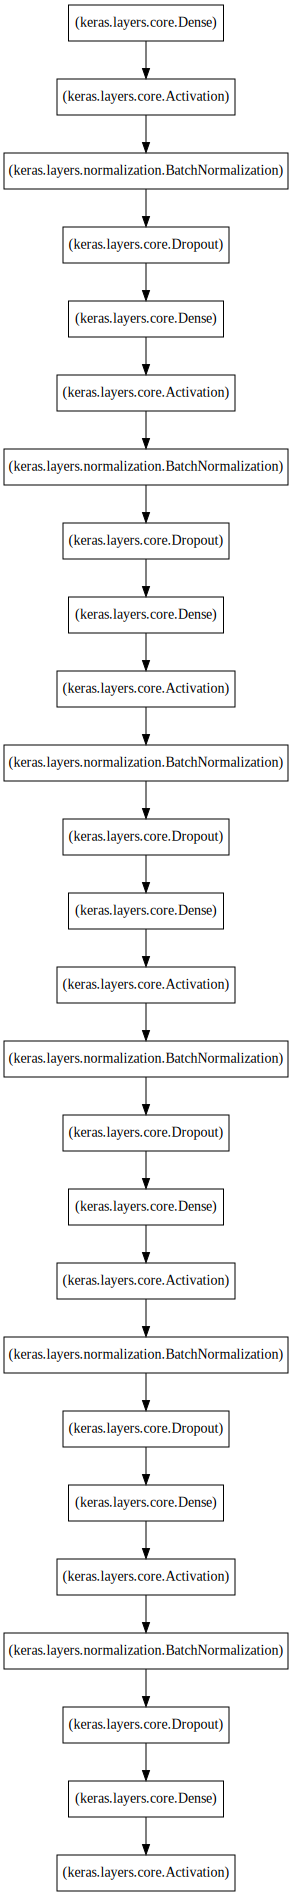

In [274]:
from keras.utils.visualize_util import plot
plot(model, to_file='model.png')
from IPython.display import SVG
from keras.utils.visualize_util import to_graph
SVG(to_graph(model).create(prog='dot', format='svg'))

In [275]:
history = History()
early_stopping = EarlyStopping(patience=5, verbose=1)
model.fit(X_train, Y_train, nb_epoch=nb_epoch, batch_size=batch_size, verbose=1, 
          show_accuracy=True, validation_split=0.1, callbacks=[history,early_stopping])
score = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=1, show_accuracy=True)
print('Test score:', score[0])
print('Test accuracy: %.2f' % (score[1]*100),"%")
#print "history.history",history.totals
classes = model.predict_classes(X_test, batch_size=32)
proba = model.predict_proba(X_test, batch_size=32)
pred = model.predict(X_test)

Train on 10540 samples, validate on 1172 samples
Epoch 1/300
10540/10540 [==============================] - 2s - loss: 0.9223 - acc: 0.6252 - val_loss: 0.8101 - val_acc: 0.6109
Epoch 2/300
10540/10540 [==============================] - 2s - loss: 0.7667 - acc: 0.6589 - val_loss: 0.6405 - val_acc: 0.7253
Epoch 3/300
10540/10540 [==============================] - 2s - loss: 0.6682 - acc: 0.7071 - val_loss: 0.5829 - val_acc: 0.7449
Epoch 4/300
10540/10540 [==============================] - 2s - loss: 0.6160 - acc: 0.7344 - val_loss: 0.5696 - val_acc: 0.7534
Epoch 5/300
10540/10540 [==============================] - 2s - loss: 0.5795 - acc: 0.7582 - val_loss: 0.5889 - val_acc: 0.7833
Epoch 6/300
10540/10540 [==============================] - 2s - loss: 0.5455 - acc: 0.7778 - val_loss: 0.5636 - val_acc: 0.7560
Epoch 7/300
10540/10540 [==============================] - 2s - loss: 0.5126 - acc: 0.8014 - val_loss: 0.5700 - val_acc: 0.7944
Epoch 8/300
10540/10540 [==============================

## Evaluate your Results

In [276]:

print("mean_squared_error",mean_squared_error(Y_test, pred)) 
cm = metrics.confusion_matrix(y_test, classes) 
print(cm)

('mean_squared_error', 0.11063677490305002)
[[1612  180   58]
 [ 164  368   65]
 [  77   77  327]]


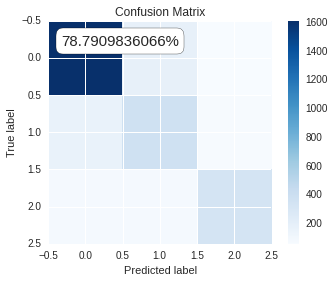

             precision    recall  f1-score   support

          0       0.87      0.87      0.87      1850
          1       0.59      0.62      0.60       597
          2       0.73      0.68      0.70       481

avg / total       0.79      0.79      0.79      2928



In [277]:
%matplotlib inline
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

fig = plt.figure()
ax = plt.subplot()
Accuracy_ = score[1]*100
at = AnchoredText(str(Accuracy_)+"%",
                      prop=dict(size=15), frameon=True,
                      loc=2,)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.5")
ax.add_artist(at)
plt.ylabel('True Label')
plt.xlabel('Predicated Label')
plot_confusion_matrix(cm, title='Confusion Matrix')
plt.show()
print(metrics.classification_report(y_test, classes))